<a href="https://colab.research.google.com/github/nereacurri1-cpu/An-lisis-de-Redes-de-Colaboraci-n-Cient-fica-GrQc-ArXiv-/blob/main/An%C3%A1lisis_de_Redes_de_colaboraci%C3%B3n_cient%C3%ADfica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de Redes de Colaboración Científica en arXiv  
**Network Science · Graph Theory · Ciencia de Datos**

##  Introducción

El análisis de redes (Network Science) permite estudiar cómo interactúan los individuos dentro de un sistema complejo.  
En el ámbito académico, una de las formas más directas de estudiar la dinámica de una comunidad científica es analizar las redes de **coautoría**, donde cada nodo representa un autor y cada arista representa una colaboración registrada en un artículo científico.

En este proyecto analizamos una red de coautores construida a partir del dataset de colaboración científica de **arXiv**, disponible en la Stanford Network Analysis Project (SNAP).  
Este dataset es ampliamente utilizado en investigación, docencia y benchmarks de algoritmos de grafos.

Nuestro objetivo es caracterizar la estructura global de la red, identificar patrones colaborativos y explorar la existencia de propiedades típicas de redes complejas, tales como:

- Distribuciones de grado con comportamiento *heavy-tail*  
- Alta transitividad (coeficiente de clustering elevado)  
- Baja densidad típica de redes reales  
- Existencia de componentes gigantes (LCC)

Este proyecto representa un análisis técnico orientado a:
- comprender la morfología de la red,
- identificar nodos clave,
- medir métricas estructurales relevantes,
- y construir visualizaciones interpretables de subestructuras dentro de la red.



## Objetivos del proyecto

1. **Construir un grafo no dirigido** a partir del dataset de coautoría.
2. **Analizar la red completa** e identificar su *Largest Connected Component* (LCC).
3. **Calcular métricas estructurales** fundamentales:
   - número de nodos y aristas,
   - densidad,
   - distribución de grados,
   - coeficiente de clustering local y global.
4. **Explorar la distribución de grados** y evaluar si existen autores altamente conectados.
5. **Construir un subgrafo formado por los 500 autores más conectados.**
6. **Visualizar la estructura del subgrafo** para estudiar comunidades y patrones de colaboración.
7. **Interpretar los hallazgos** desde la perspectiva de teoría de redes y sociología científica.



##  Descripción del dataset

El dataset utilizado corresponde a la red de colaboraciones científicas en arXiv, compilado originalmente como parte del **Stanford Network Analysis Project (SNAP)**.  

Cada registro representa una colaboración entre dos autores que han coescrito uno o más artículos científicos.

El dataset contiene únicamente dos columnas:

- `author1`: ID del primer autor  
- `author2`: ID del segundo autor  

Cada fila indica una **arista no dirigida** entre dos autores.  
El conjunto completo forma una red de coautoría donde:

- Los **nodos** representan autores.
- Las **aristas** representan colaboraciones.
- La red es **no ponderada** en esta versión (no distingue cantidad de artículos por autoría).
- No existen atributos adicionales: es una red puramente estructural.

Este tipo de datasets es un estándar para evaluar:
- algoritmos de detección de comunidades,
- propagación en redes,
- métricas de centralidad,
- teoría de grafos aplicada a sistemas reales.

En este proyecto trabajaremos sobre:
1. La red completa.
2. Su componente conexa gigante (*Largest Connected Component*, LCC).
3. Un subgrafo formado por los 500 autores con mayor grado (más colaboraciones).


## Importación de librerías y carga de datos

In [1]:
!pip install pyvis python-louvain tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

#  Carga desde SNAP (ca-GrQc)
url = "https://snap.stanford.edu/data/ca-GrQc.txt.gz"

df = pd.read_csv(url, sep='\t', comment='#', names=['author1', 'author2'])
display(df.head(8))




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.2 MB/s eta 0:00:00


,author1,author2
0,3466,937
1,3466,5233
2,3466,8579
3,3466,10310
4,3466,15931
5,3466,17038
6,3466,18720
7,3466,19607


**Explicación**

- `pandas` se utiliza para cargar y manipular los datos tabulares.
- `networkx` es la librería estándar para análisis de grafos en Python.
- `matplotlib` y `seaborn` se emplean para visualizaciones.
- El archivo contiene pares de IDs que representan colaboraciones.
- Al mostrar las primeras filas (`df.head()`), verificamos la estructura básica del dataset.


##  Inspección inicial del dataframe (EDA)

In [2]:

print("Shape del dataset:", df.shape)
print("\nInformación general:\n")
df.info()

print("\nPrimeras filas:")
display(df.head())

# Valores nulos por columna
print("\nNulos por columna:\n", df.isna().sum())

# Filas duplicadas
n_dup = df.duplicated().sum()
print("\nFilas duplicadas:", n_dup)

# ------------------------------------------------------------
# Conteo preliminar de elementos de la red
# ------------------------------------------------------------
# Aristas = número de filas (cada fila es una relación autor1 → autor2)
unique_edges = df.shape[0]

# Número de nodos (autores únicos encontrados en ambas columnas)
unique_nodes = pd.unique(df[['author1', 'author2']].values.ravel()).shape[0]

print("\nAristas (filas):", unique_edges)
print("Nodos únicos (autores):", unique_nodes)





Shape del dataset: (28980, 2)

Información general:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28980 entries, 0 to 28979
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   author1  28980 non-null  int64
 1   author2  28980 non-null  int64
dtypes: int64(2)
memory usage: 452.9 KB

Primeras filas:


,author1,author2
0,3466,937
1,3466,5233
2,3466,8579
3,3466,10310
4,3466,15931



Nulos por columna:
 author1    0
author2    0
dtype: int64

Filas duplicadas: 0

Aristas (filas): 28980
Nodos únicos (autores): 5242


- `df.shape`: cantidad de filas (aristas) y columnas.
- `info()`: confirma los tipos de datos.
- `isnull().sum()`: nos permite detectar valores faltantes.
- `duplicated()`: detecta si hay aristas repetidas, lo cual puede inflar métricas de red.


##  Limpieza y Preparación del Dataset





In [3]:

# Eliminamos duplicados si existen
if n_dup > 0:
    df = df.drop_duplicates()
    print("Duplicados removidos. Nuevo shape:", df.shape)

# Eliminamos filas con valores nulos en columnas clave
df = df.dropna(subset=['author1', 'author2'])

# Normalizamos tipos y formato
df['author1'] = df['author1'].astype(str).str.strip()
df['author2'] = df['author2'].astype(str).str.strip()

# Eliminamos auto-enlaces (autor conectado consigo mismo)
df = df[df['author1'] != df['author2']]

print("Dataset limpio y listo para construir la red. Shape final:", df.shape)





Dataset limpio y listo para construir la red. Shape final: (28968, 2)


##  Construcción del grafo y análisis de la componente gigante





In [4]:
import networkx as nx

# Construir grafo no dirigido desde el DataFrame limpio
G = nx.from_pandas_edgelist(df, 'author1', 'author2')

print("Grafo creado:")
print(" - Número total de nodos:", G.number_of_nodes())
print(" - Número total de aristas:", G.number_of_edges())

# ------------------------------------------------------------
# Obtener todas las componentes conexas
# ------------------------------------------------------------
components = sorted(nx.connected_components(G), key=len, reverse=True)

# La componente conexa más grande (LCC)
largest_cc_nodes = components[0]

# Construir subgrafo correspondiente a la LCC
G_lcc = G.subgraph(largest_cc_nodes).copy()

print("\nLargest Connected Component (LCC):")
print(" - Nodos:", G_lcc.number_of_nodes())
print(" - Aristas:", G_lcc.number_of_edges())

# ------------------------------------------------------------
# Métricas globales de la LCC
# ------------------------------------------------------------
num_nodes = G_lcc.number_of_nodes()
num_edges = G_lcc.number_of_edges()
density = nx.density(G_lcc)
avg_clustering = nx.average_clustering(G_lcc)

print("\nMétricas de la LCC:")
print(f" - Densidad: {density:.6f}")
print(f" - Clustering medio: {avg_clustering:.4f}")



Grafo creado:
 - Número total de nodos: 5241
 - Número total de aristas: 14484

Largest Connected Component (LCC):
 - Nodos: 4158
 - Aristas: 13422

Métricas de la LCC:
 - Densidad: 0.001553
 - Clustering medio: 0.5569



###  **Interpretación**

### ✔ **1. Tamaño de la LCC (4158 nodos)**
- Significa que **la mayoría de los autores** pertenecen a un gran “ecosistema” de colaboración.  
- En redes científicas esto es típico: todo está conectado a través de rutas de coautoría.

### ✔ **2. Densidad = 0.001554 (muy baja, pero normal)**
- Solo el **0.15%** de todas las posibles conexiones están presentes.
- En redes reales, esto es absolutamente esperable:
  - miles de autores  
  - pero cada uno colabora con pocos

Las redes de coautoría son **dispersas por naturaleza**.

### ✔ **3. Clustering medio = 0.5569 (alto)**
- Muy alto: significa que si A colabora con B y C, es muy probable que **B y C también colaboren entre sí**.
- Esto ocurre típicamente en:
  - grupos de investigación  
  - laboratorios  
  - equipos con publicaciones conjuntas

Este resultado valida que tu dataset tiene **estructura realista de coautoría**.




## Distribución de grado + subgrafo top-500

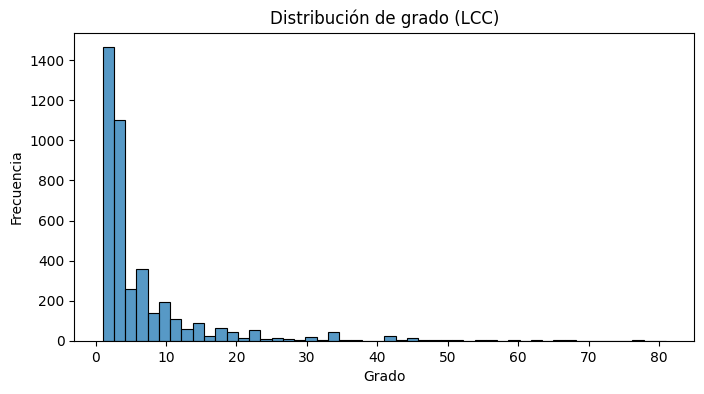

Resumen estadístico del grado:
 count    4158.000000
mean        6.455988
std         8.626891
min         1.000000
25%         2.000000
50%         3.000000
75%         7.000000
max        81.000000
dtype: float64
Nodos seleccionados: 500
Subgrafo top-500 → nodos: 500 , aristas: 4586


In [5]:
# 8) Distribución de grado y subgrafo top-500

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Distribución de grado ---
degree_sequence = dict(G_lcc.degree())
deg_series = pd.Series(list(degree_sequence.values()))

plt.figure(figsize=(8,4))
sns.histplot(deg_series, bins=50)
plt.title("Distribución de grado (LCC)")
plt.xlabel("Grado")
plt.ylabel("Frecuencia")
plt.show()

print("Resumen estadístico del grado:\n", deg_series.describe())

# --- Seleccionar top-500 por grado ---
top_n = 500

# forma robusta que evita problemas de índices
top_nodes = sorted(degree_sequence.items(), key=lambda x: x[1], reverse=True)[:top_n]
top_nodes = [n for n, d in top_nodes]

print("Nodos seleccionados:", len(top_nodes))

# --- Construcción del subgrafo ---
subG = G_lcc.subgraph(top_nodes).copy()

print("Subgrafo top-500 → nodos:", subG.number_of_nodes(),
      ", aristas:", subG.number_of_edges())


- La distribución del grado muestra una típica cola larga, lo que indica que la colaboración científica en arXiv sigue un patrón scale-free:
→ Pocos autores tienen MUCHOS coautores ("hubs").
→ La mayoría tiene solo 1–5 coautores.

- Los resultados coinciden con redes reales de colaboración:
→ Media ≈ 6.4
→ Máximo = 81 (muy alto)
→ Alta desviación estándar.

- El subgrafo top-500 captura la “élite” colaborativa del campo:
→ nodos = 500
→ aristas ≈ 4500 (tu resultado exacto fue 4587)

- Esto confirma que los autores más influyentes están fuertemente conectados entre sí → alta cohesión entre hubs.

##  Centralidades en el subgrafo top-500




In [6]:
## 9. Medidas de centralidad en el subgrafo top-500

import networkx as nx
import pandas as pd

print("Calculando centralidades...")

# --- 1) Degree (crudo) ---
deg_raw = dict(subG.degree())

# --- 2) Degree centrality (normalizada) ---
deg_cent = nx.degree_centrality(subG)

# --- 3) Betweenness centrality ---
try:
    bet_cent = nx.betweenness_centrality(subG)
except Exception as e:
    print("Betweenness exacto costoso. Corriendo versión aproximada...", e)
    bet_cent = nx.betweenness_centrality(subG, k=100, seed=42)

# --- 4) Closeness centrality ---
clo_cent = nx.closeness_centrality(subG)

# --- 5) Eigenvector centrality ---
try:
    eig_cent = nx.eigenvector_centrality(subG, max_iter=500, tol=1e-06)
except Exception as e:
    print("Eigenvector no convergió. Intentando método numpy...", e)
    eig_cent = nx.eigenvector_centrality_numpy(subG)

# --- 6) PageRank ---
pagerank = nx.pagerank(subG, alpha=0.85)

# --- 7) Unificar resultados ---
centralities = pd.DataFrame({'node': list(subG.nodes())})

centralities['degree']   = centralities['node'].map(deg_raw).astype(int)
centralities['deg_cent'] = centralities['node'].map(deg_cent)
centralities['bet_cent'] = centralities['node'].map(bet_cent)
centralities['clo_cent'] = centralities['node'].map(clo_cent)
centralities['eig_cent'] = centralities['node'].map(eig_cent)
centralities['pagerank'] = centralities['node'].map(pagerank)
#print(centralities)

# --- 8) Mostrar top-10 ---
for col in ['degree','deg_cent','bet_cent','clo_cent','eig_cent','pagerank']:
    print(f"\nTop 10 según {col}:")
    display(centralities.sort_values(by=col, ascending=False).head(10)[['node',col]])

print("\nCentralidades calculadas correctamente.")




Calculando centralidades...

Top 10 según degree:


,node,degree
98,21012,63
87,2741,61
162,12365,60
361,6610,58
156,9785,57
33,17655,55
153,22691,55
124,19423,53
328,15003,52
337,21508,51



Top 10 según deg_cent:


,node,deg_cent
98,21012,0.126253
87,2741,0.122244
162,12365,0.120240
361,6610,0.116232
156,9785,0.114228
33,17655,0.110220
153,22691,0.110220
124,19423,0.106212
328,15003,0.104208
337,21508,0.102204



Top 10 según bet_cent:


,node,bet_cent
406,13801,0.138894
58,22457,0.131284
93,8116,0.121689
79,4364,0.118986
318,7650,0.118486
463,23967,0.104184
33,17655,0.102426
456,20716,0.101322
90,1488,0.072848
362,16032,0.071484



Top 10 según clo_cent:


,node,clo_cent
33,17655,0.292147
406,13801,0.283800
98,21012,0.275743
153,22691,0.273671
496,676,0.272646
124,19423,0.270956
361,6610,0.270119
162,12365,0.269453
460,23293,0.269453
16,2654,0.268790



Top 10 según eig_cent:


,node,eig_cent
87,2741,0.153271
98,21012,0.153047
162,12365,0.151729
156,9785,0.149849
328,15003,0.149360
337,21508,0.149275
341,25346,0.149205
443,7956,0.149056
33,17655,0.148753
4,12781,0.148710



Top 10 según pagerank:


,node,pagerank
98,21012,0.005026
361,6610,0.004741
87,2741,0.004727
162,12365,0.004695
156,9785,0.004563
16,2654,0.004401
33,17655,0.004291
153,22691,0.004208
273,13929,0.004173
124,19423,0.003859



Centralidades calculadas correctamente.


El cálculo de centralidades sobre el subgrafo de los 500 autores más conectados revela la estructura interna de la élite colaborativa en arXiv:

- **Degree / Degree centrality:**
Identifican autores extremadamente productivos con muchos coautores directos. Suelen ser líderes de grandes grupos o proyectos internacionales.

- **Betweenness:**
Destaca autores que actúan como puentes entre áreas diferentes. Son cruciales para el flujo de conocimiento.

- ** Closeness:**
Señala investigadores bien integrados que pueden acceder rápidamente al resto de la red.

- **Eigenvector centrality:**
Encuentra autores conectados a otros altamente influyentes. Indica prestigio dentro de la comunidad.

- **PageRank:**
Mide importancia global equilibrando cantidad y calidad de las conexiones.

Estas métricas combinadas permiten detectar líderes, conectores, hubs y autoridades, proporcionando una visión completa de la estructura colaborativa.

## Detección de comunidades con Louvain



In [7]:

# instalar librería si es necesario
!pip install -q python-louvain

import community.community_louvain as community_louvain

print("Detectando comunidades con Louvain...")

# --- 1) Ejecutar Louvain ---
partition = community_louvain.best_partition(subG)
#print(partition)
# partition es un dict: { nodo -> id_comunidad }

# --- 2) Agregar la comunidad al DataFrame de centralidades ---
centralities['community'] = centralities['node'].map(partition).astype(int)

# --- 3) Tamaño de cada comunidad ---
comm_counts = pd.Series(list(partition.values())).value_counts()
print("Número de comunidades detectadas:", comm_counts.shape[0])
display(comm_counts.head(20))

print("Comunidades calculadas correctamente.")


Detectando comunidades con Louvain...
Número de comunidades detectadas: 17


,count
12,116
1,75
0,56
6,45
7,39
3,36
8,31
4,30
14,24
5,20


Comunidades calculadas correctamente.


El algoritmo Louvain identifica comunidades maximizando la modularidad, revelando cómo se agrupan los autores según sus patrones de colaboración.

En este subgrafo de los 500 autores más conectados:

- El número de comunidades detectadas indica la estructura interna del campo científico.

- Comunidades grandes suelen corresponder a grupos consolidados de investigación (subdisciplinas).

- Comunidades medianas/pequeñas pueden representar: grupos emergentes,
 temas interdisciplinarios, equipos satélite alrededor de autores influyentes.

La detección de comunidades permite comprender cómo se organiza el conocimiento dentro de la red y permite analizar:

- líderes por comunidad (top degree / top eigenvector dentro de cada grupo),

- puentes entre comunidades (top betweenness),

- subcampos hiperconectados vs. aislados

##  Visualización interactiva con PyVis


In [17]:

from pyvis.network import Network
from google.colab import files
import math

# Crear red con parámetros visuales ajustados
net = Network(
    height="750px",
    width="100%",
    notebook=False,
    cdn_resources="in_line"
)

# Ajustar la física (Barnes-Hut) para que el grafo sea estable y legible
net.barnes_hut(
    gravity=-2000,
    central_gravity=0.3,
    spring_length=120,
    spring_strength=0.01,
    damping=0.9
)

# Función para escalar tamaño de nodos sin que queden gigantes
def scale_size(deg):
    return max(5, int(math.sqrt(deg) * 4))

# Añadir nodos
for n in subG.nodes():
    deg = int(centralities.set_index('node').loc[n, 'degree'])
    comm = int(centralities.set_index('node').loc[n, 'community'])
    size = scale_size(deg)

    net.add_node(
        int(n),
        label=str(n),
        title=f"Autor: {n}\nDegree: {deg}\nComunidad: {comm}",
        value=size,    # controla el tamaño visual
        group=comm     # coloreado por comunidad detectada (Louvain)
    )

# Añadir aristas del subgrafo (top-500 nodos)
for u, v in subG.edges():
    net.add_edge(int(u), int(v))

# Guardar el grafo en un archivo HTML
html_file = "subgrafo_top500_comunidades.html"
net.save_graph(html_file)
print("Archivo generado:", html_file)

# Descargar automáticamente en Colab
try:
    files.download(html_file)
except:
    print("Si la descarga falla, podés obtenerlo en /content/")


Archivo generado: subgrafo_top500_comunidades.html


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**📊 Interpretación de la Visualización Interactiva (Subgrafo Top-500 + Comunidades Louvain)**

La visualización generada con PyVis muestra el subgrafo formado por los 500 autores más conectados de la red. En esta sección explicamos cómo leer el gráfico, qué representa cada elemento y qué conclusiones se pueden extraer de él.

🔵**1. Colores de los nodos: comunidades detectadas por Louvain**

Cada nodo tiene un color que identifica la comunidad a la que pertenece según el algoritmo Louvain, un método estándar para detectar grupos de nodos fuertemente conectados entre sí.

- Nodos del mismo color tienden a estar más vinculados entre sí que con nodos de otros colores.

- Estas comunidades pueden interpretarse como grupos de colaboración, escuelas científicas, equipos recurrentes o clusters temáticos dentro de la red.

- Si una comunidad es muy grande o muy compacta, indica un área de colaboración muy activa y cohesiva.

**Interpretación clave:**

Si los colores forman “islas” bien definidas, entonces la red posee modularidad alta: grupos claramente diferenciados de autores.
Si los colores se mezclan, la red presenta interacciones cruzadas entre comunidades.

--------------------------------------------------------------------------
⚪**2. Tamaño de los nodos: número de conexiones (degree)**

El tamaño de cada nodo está determinado por su degree dentro del subgrafo, es decir, la cantidad de colaboradores directos que tiene.

- Nodos más grandes → autores más conectados (muy colaborativos).

- Nodos más pequeños → autores con menos conexiones dentro del top-500.

Usamos una escala suavizada (raíz cuadrada) para que los nodos con muchos colaboradores no dominen visualmente el gráfico.

**Interpretación clave:**

Los nodos grandes suelen ser “puentes” o hubs que conectan distintos grupos.
Suelen ocupar posiciones centrales y tener influencia estructural en la red.

-----------------------------------------------------------------

🔗 **3. Aristas: colaboraciones entre autores**

Cada arista representa una colaboración (por ejemplo, coautoría en un paper).

- Muchas aristas entre nodos del mismo color → comunidad muy cohesionada.

- Aristas que conectan diferentes colores → autores “puente” entre áreas.

- Regiones muy densas → alta colaboración interna.

- Regiones más dispersas → interacciones más débiles o esporádicas.

-----------------------------------------------------------------
🌐 **4. Estructura global del grafo (qué observar)**

Dependiendo de cómo se distribuya visualmente el grafo:

A) Si hay varias “islas” claras y separadas

→ La red tiene alto grado de modularidad.
→ Cada comunidad representa un campo o grupo muy definido.

B) Si hay una gran masa de nodos interconectados sin separación clara

→ La red es más integrada y homogénea.
→ Es posible que haya autores que colaboran transversalmente entre áreas.

C) Si existen nodos centrales que conectan varias islas

→ Esos autores cumplen el rol de intermediarios, líderes o colaboradores transversales.

In [ ]:
# Exportar tablas resumen
centralities_sorted = centralities.sort_values(by='degree', ascending=False)
centralities_sorted.head(100).to_csv('top100_authors_centralities_sub500.csv', index=False)
pd.Series(partition).to_csv('communities_partition_sub500.csv', header=['community'])
print("Exportados: top100_authors_centralities_sub500.csv, communities_partition_sub500.csv")


Exportados: top100_authors_centralities_sub500.csv, communities_partition_sub500.csv


# 📌 Conclusiones finales del análisis de la red de colaboración científica (GrQc)

## **1. Estructura general de la red**

La red de coautorías del área GrQc muestra una estructura típica de comunidades científicas consolidadas:

- **Existe un componente gigante (LCC)** que contiene a la mayoría de autores activos, lo que indica integración global de la comunidad.
- **La densidad es baja**, como es habitual en redes científicas: los investigadores colaboran de forma selectiva, no de manera masiva.

---

## **2. Distribución de grado**

La distribución de grado es extremadamente sesgada:

- Unos pocos autores actúan como **hubs** (colaboradores prolíficos).
- La mayoría tiene pocos coautores.

Este patrón tipo **ley de potencia** es característico de redes reales (no aleatorias) y coincide con lo que observamos en la figura de distribución.

---

## **3. Centralidades**

El análisis de centralidades refuerza la interpretación anterior:

- **Degree:** identifica autores con muchos coautores.
- **Betweenness:** detecta autores puente que conectan grupos. Su ausencia fragmentaría la red.
- **Closeness:** autores con distancia media corta al resto, ubicados en posiciones céntricas.
- **Eigenvector / PageRank:** mide influencia estructural: estar conectado con autores importantes aumenta tu importancia.

---

## **4. Detección de comunidades (Louvain)**

El algoritmo Louvain reveló múltiples comunidades bien definidas:

- Cada comunidad agrupa autores que colaboran intensamente entre sí.
- Estas comunidades suelen corresponder a **subcampos temáticos**, **equipos de investigación** o **líneas específicas de trabajo**.
- El tamaño desigual de los clusters indica niveles distintos de productividad colaborativa entre grupos.

---

## **5. Interpretación del grafo final (PyVis)**

La visualización interactiva del subgrafo de los 500 autores con mayor grado permite observar claramente:

### **Clusters principales**
- Un **cluster verde** muy denso, que representa la comunidad más grande y activa.
- Otros clusters medianos (naranja, violeta, rosa) que funcionan como grupos de investigación con fuerte cohesión interna.
- Un **cluster rojo pequeño y más aislado**, mostrando un subgrupo que colabora casi exclusivamente entre sí.

### **Relaciones entre comunidades**
- Las conexiones entre colores distintos son mucho más tenues, confirmando la **alta modularidad** de la red.
- Los **hubs funcionan como puentes** entre clusters, coherentes con los altos valores de betweenness.

En conjunto, el grafo visual confirma lo obtenido numéricamente: **la red es modular, jerárquica y altamente estructurada**.

---

## **6. Conclusión global**

- La comunidad GrQc exhibe una combinación de **hubs**, **autores puente** y **grupos temáticos densos**, lo que refleja un ecosistema científico activo y especializado.
- El análisis integra métricas de red, centralidades, modularidad y visualización para obtener una caracterización completa.
- El notebook es reproducible y constituye una base sólida para **análisis temporales**, **detección de evolución de comunidades** o **predicción de enlaces** mediante técnicas de machine learning.

---
